<a href="https://colab.research.google.com/github/VictoorV/Breast_cancer/blob/main/Projet_cancer_du_sein.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt comet_ml  # install

import torch
import utils
display = utils.notebook_init()  # checks"""

YOLOv5 🚀 v7.0-383-g1435a8ee Python-3.10.12 torch-2.5.0+cu121 CPU


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.6/107.7 GB disk)


In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hayder17/breast-cancer-detection")

print("Path to dataset files:", path)

100%|██████████| 87.2M/87.2M [00:02<00:00, 33.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/hayder17/breast-cancer-detection/versions/1


In [2]:
!cp -r /root/.cache/kagglehub/datasets/hayder17/breast-cancer-detection/versions/1 /content/breast-cancer-detection


In [3]:
import os
current_directory = os.getcwd()
print("Ancien répertoire :", current_directory)
os.chdir(current_directory+'/breast-cancer-detection')
current_directory = os.getcwd()
print("Nouveau répertoire :", current_directory)

Ancien répertoire : /content
Nouveau répertoire : /content/breast-cancer-detection


In [ ]:
#!rm -rf /content/yolov5/yolov5


In [4]:
pip install torchinfo

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import datasets
from PIL import Image
import torchvision.transforms as T
import torch
from torch import nn, optim
from torchvision import models
from torchinfo import summary
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [6]:
transform_train = transforms.Compose([
    transforms.Resize((640, 640)),  # Redimensionner les images
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Charger les images depuis le dossier
train_dataset = datasets.ImageFolder(
    root="/content/breast-cancer-detection/train",
    transform=transform_train
)

valid_dataset = datasets.ImageFolder(
    root="/content/breast-cancer-detection/valid",
    transform=transform
)

test_dataset = datasets.ImageFolder(
    root="/content/breast-cancer-detection/test",
    transform=transform
)

In [ ]:
positive = 0
for _, lbl in train_dataset:
  positive+=lbl
print(positive/len(train_dataset))

0.3385328836424958


In [7]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Classes: ['0', '1']
Shape des images: torch.Size([4, 3, 640, 640])


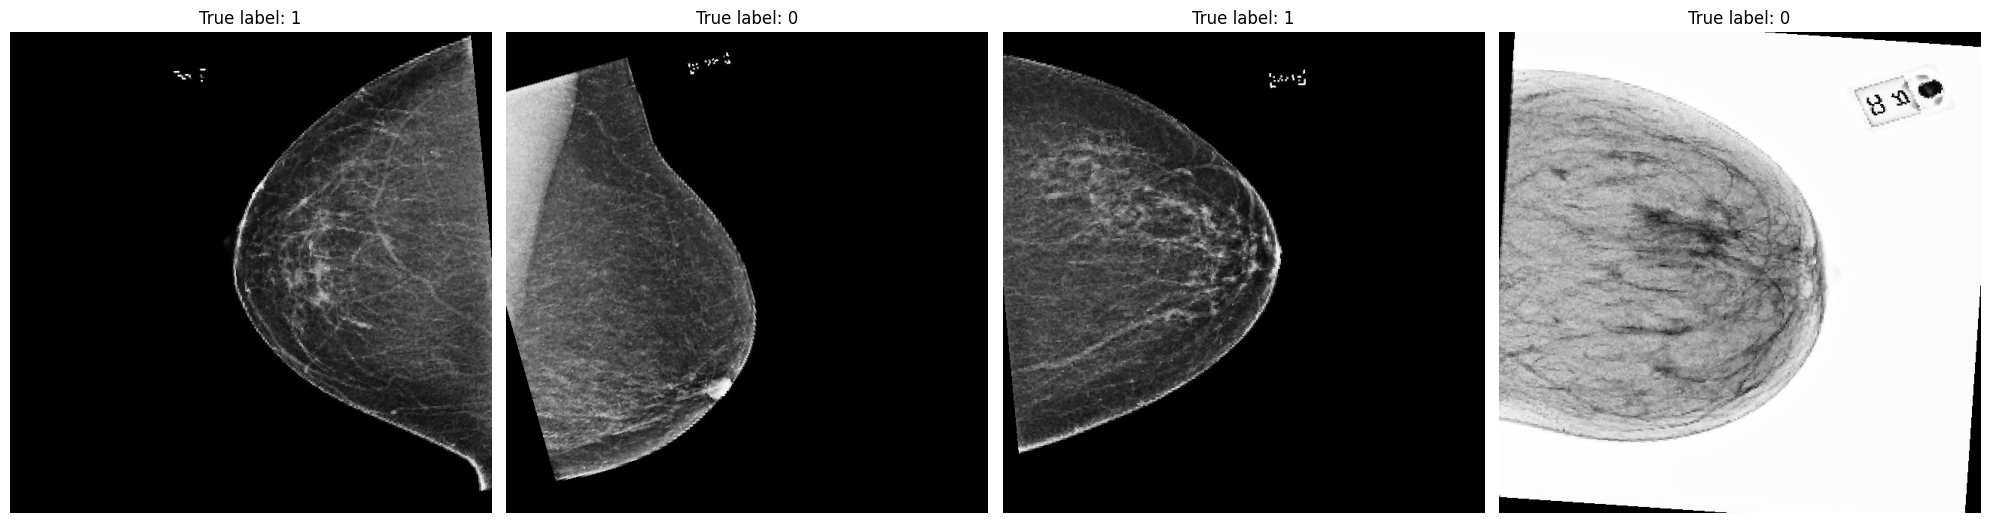

In [8]:
# Aperçu des classes
class_names = train_dataset.classes
print("Classes:", class_names)

torch.manual_seed(0)
for images, labels in train_loader:
    images = images[0:4]
    labels = labels[0:4]
    print("Shape des images:", images.shape)

    inv_transform = transforms.Normalize(
        mean=[-0.485 / 0.229, - 0.456 / 0.224, -0.406 / 0.225],
        std=[1/0.229, 1/0.224, 1/0.225])
    unnormalized_images = [inv_transform(img) for img in images]
    transform = T.ToPILImage()

    fig, ax = plt.subplots(1,4, figsize=(20,20))
    for i in range(0,4):
      ax[i].imshow(transform(unnormalized_images[i]))
      ax[i].set_title(f"True label: {labels[i].item()}")
      ax[i].axis("off")
    plt.tight_layout()
    plt.show()
    break

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [79]:
model = models.resnet50(pretrained=True)

In [80]:
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [81]:
#model.fc = nn.Linear(2048,2)
model.fc = nn.Sequential(nn.Dropout(p=0.3),
    nn.Linear(2048,2)
  )
model.fc

Sequential(
  (0): Dropout(p=0.3, inplace=False)
  (1): Linear(in_features=2048, out_features=2, bias=True)
)

In [82]:
summary(model, input_size=(1, 3, 640, 640))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 2]                    --
├─Conv2d: 1-1                            [1, 64, 320, 320]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 320, 320]         128
├─ReLU: 1-3                              [1, 64, 320, 320]         --
├─MaxPool2d: 1-4                         [1, 64, 160, 160]         --
├─Sequential: 1-5                        [1, 256, 160, 160]        --
│    └─Bottleneck: 2-1                   [1, 256, 160, 160]        --
│    │    └─Conv2d: 3-1                  [1, 64, 160, 160]         4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 160, 160]         128
│    │    └─ReLU: 3-3                    [1, 64, 160, 160]         --
│    │    └─Conv2d: 3-4                  [1, 64, 160, 160]         36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 160, 160]         128
│    │    └─ReLU: 3-6                    [1, 64, 160, 160]         --
│ 

In [83]:
for param in model.parameters():
    param.requires_grad = False

for param in model.layer3.parameters():
    param.requires_grad = True

for param in model.layer4.parameters():
    param.requires_grad = True

for param in model.fc.parameters():
    param.requires_grad = True

In [84]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name} is trainable")
    else:
        print(f"{name} is frozen")

conv1.weight is frozen
bn1.weight is frozen
bn1.bias is frozen
layer1.0.conv1.weight is frozen
layer1.0.bn1.weight is frozen
layer1.0.bn1.bias is frozen
layer1.0.conv2.weight is frozen
layer1.0.bn2.weight is frozen
layer1.0.bn2.bias is frozen
layer1.0.conv3.weight is frozen
layer1.0.bn3.weight is frozen
layer1.0.bn3.bias is frozen
layer1.0.downsample.0.weight is frozen
layer1.0.downsample.1.weight is frozen
layer1.0.downsample.1.bias is frozen
layer1.1.conv1.weight is frozen
layer1.1.bn1.weight is frozen
layer1.1.bn1.bias is frozen
layer1.1.conv2.weight is frozen
layer1.1.bn2.weight is frozen
layer1.1.bn2.bias is frozen
layer1.1.conv3.weight is frozen
layer1.1.bn3.weight is frozen
layer1.1.bn3.bias is frozen
layer1.2.conv1.weight is frozen
layer1.2.bn1.weight is frozen
layer1.2.bn1.bias is frozen
layer1.2.conv2.weight is frozen
layer1.2.bn2.weight is frozen
layer1.2.bn2.bias is frozen
layer1.2.conv3.weight is frozen
layer1.2.bn3.weight is frozen
layer1.2.bn3.bias is frozen
layer2.0.con

# Boucle d'entrainement

In [85]:
model = model.to(device)

In [88]:
class_weights = torch.tensor([1, 1.7]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
params_to_update = list(model.layer3.parameters()) + list(model.layer4.parameters()) + list(model.fc.parameters())

optimizer = optim.SGD(params_to_update, lr=1e-3, momentum=0.9, weight_decay=1e-4)
#optimizer = optim.AdamW(params_to_update, lr=5e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)

running_loss_all = []
valid_loss_all = []
best_val_loss = float('inf')
best_model_params = None

In [89]:
import copy
epochs = 15

for epoch in range(epochs):
  running_loss = 0.0

  current_lr = scheduler.get_last_lr()[0]
  print(f"Epoch [{epoch+1}/{epochs}], Current LR: {current_lr:.6f}")

  model.train()

  for images, labels in train_loader:
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()
  model.eval()
  val_loss = 0.0
  with torch.no_grad():
      for images, labels in valid_loader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          loss = criterion(outputs, labels)
          val_loss += loss.item()
  print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {running_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(valid_loader):.4f}")

  running_loss_all.append(running_loss/len(train_loader))
  valid_loss_all.append(val_loss/len(valid_loader))

  if val_loss/len(valid_loader) < best_val_loss:
        best_val_loss = val_loss/len(valid_loader)
        best_model_params = copy.deepcopy(model.state_dict())
        print('Model saved')

  scheduler.step()

last_model_params = copy.deepcopy(model.state_dict())

Epoch [1/15], Current LR: 0.001000
Epoch [1/15], Training Loss: 0.7272, Validation Loss: 0.7443
Model saved
Epoch [2/15], Current LR: 0.001000
Epoch [2/15], Training Loss: 0.7000, Validation Loss: 0.6818
Model saved
Epoch [3/15], Current LR: 0.001000
Epoch [3/15], Training Loss: 0.6812, Validation Loss: 0.6538
Model saved
Epoch [4/15], Current LR: 0.000700
Epoch [4/15], Training Loss: 0.6653, Validation Loss: 0.6646
Epoch [5/15], Current LR: 0.000700
Epoch [5/15], Training Loss: 0.6599, Validation Loss: 0.6538
Model saved
Epoch [6/15], Current LR: 0.000700
Epoch [6/15], Training Loss: 0.6561, Validation Loss: 0.6496
Model saved
Epoch [7/15], Current LR: 0.000490
Epoch [7/15], Training Loss: 0.6428, Validation Loss: 0.6496
Model saved
Epoch [8/15], Current LR: 0.000490
Epoch [8/15], Training Loss: 0.6301, Validation Loss: 0.6432
Model saved
Epoch [9/15], Current LR: 0.000490
Epoch [9/15], Training Loss: 0.6414, Validation Loss: 0.6482
Epoch [10/15], Current LR: 0.000343
Epoch [10/15], T

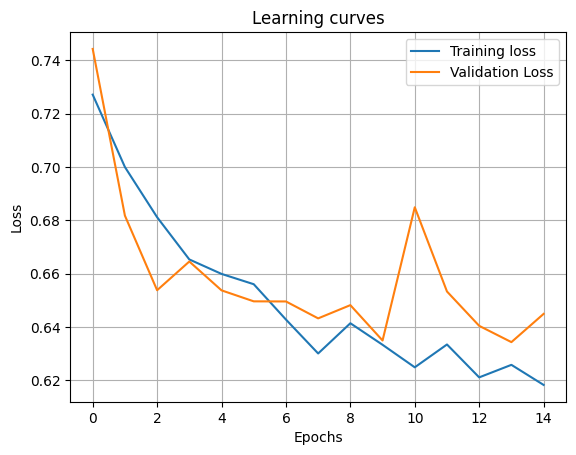

In [90]:
plt.plot(running_loss_all, label='Training loss')
plt.plot(valid_loss_all, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Learning curves")
plt.grid()
plt.legend()
plt.show()

In [93]:
model.load_state_dict(best_model_params)
#model.load_state_dict(last_model_params)

<All keys matched successfully>

In [102]:
from sklearn.metrics import classification_report
label_true = []
label_pred = []
probas_list_class_1 = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, pred_lab = torch.max(outputs, dim = 1)
        probas_class_1 = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()

        probas_list_class_1.extend(probas_class_1)
        label_true.extend(labels.cpu().numpy())
        label_pred.extend(pred_lab.cpu().numpy())

In [103]:
print(classification_report(label_true, label_pred))

              precision    recall  f1-score   support

           0       0.74      0.72      0.73       208
           1       0.56      0.59      0.57       128

    accuracy                           0.67       336
   macro avg       0.65      0.65      0.65       336
weighted avg       0.67      0.67      0.67       336



<Axes: >

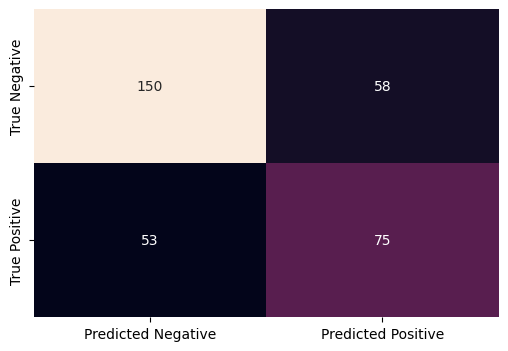

In [104]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(label_true, label_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cbar=False,
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['True Negative', 'True Positive'])

In [125]:
torch.save(model.state_dict(), 'best_model_weights.pth')
print("Modèle sauvegardé sur Colab.")

Modèle sauvegardé sur Colab.


In [126]:
from google.colab import files

files.download('best_model_weights.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>